# Project Details:

* Title: Reboot: Box-Plots for Education
* Team Members: Ayesha Bhimdiwala, JanakiKhatiwada, Sunanda Unni

# Introduction

The **Reboot: Box-Plots for Education** is a data science challenge sponsored by the Education Resource Strategies (ERS). It is an on-going competition which will end in February. 

In this project, we plan to solve a **multi-class-multi-label classification problem** with the goal of attaching canonical labels to the freeform text in budget line items. These labels let ERS understand how schools are spending money and tailor their strategy recommendations to improve outcomes for students, teachers, and administrators.




##  Project Problem

Predict the probability that a certain label from each target category is attached to a budget line item.

## Data  Description

Train data set, "train.csv" has 25 features. Out of these, 2 are numerical and rest are categorical. Also out of 25, 9 are target features.

Following are the features that will be used for building model and predicting probabilities.

  *  FTE float - If an employee, the percentage of full-time that the employee works.
  *  Facility_or_Department - If expenditure is tied to a department/facility, that department/facility.
  *  Function_Description - A description of the function the expenditure was serving.
  *  Fund_Description - A description of the source of the funds.
  *  Job_Title_Description - If this is an employee, a description of that employee's job title.
  *  Location_Description - A description of where the funds were spent.
  *  Object_Description - A description of what the funds were used for.
  *  Position_Extra - Any extra information about the position that we have.
  *  Program_Description - A description of the program that the funds were used for.
  *  SubFund_Description - More detail on Fund_Description
  *  Sub_Object_Description - More detail on Object_Description
  *  Text_1 - Any additional text supplied by the district.
  *  Text_2 - Any additional text supplied by the district.
  *  Text_3 - Any additional text supplied by the district.
  *  Text_4 - Any additional text supplied by the district.
  *  Total float - The total cost of the expenditure.

And these are target features we have to predict probability for labeling each row.

  *  Function
  *  Object_Type
  *  Operating_Status
  *  Position_Type
  *  Pre-K
  *  Reporting
  *  Sharing
  *  Student_type
  *  Use


# ETL Phase

## Prepare the notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from collections import Counter
from scipy import sparse, stats
from sklearn import preprocessing as prep
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, StratifiedKFold
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.utils import check_array
from time import time

#from fancyimpute import MICE

%matplotlib inline

In [5]:
%ls -l data/education_reboot/TrainingData.csv
#%ls -l /Users/ayeshabhimdiwala/AML_AyeshaBhimdiwala/Project/data/education_reboot

-rw-r--r--@ 1 ayeshabhimdiwala  staff  125429589 Oct 29  2014 data/education_reboot/TrainingData.csv


In [6]:
path = os.path.join('data','education_reboot') #make sure you have the same path in your parent directory
path

'data/education_reboot'

In [7]:
def load_data(datapath,data):
    csv_path = os.path.join(datapath,data)
    df = pd.read_csv(csv_path,index_col=0)
    print(df.info())
    display(df.head())
    print()
    return df

In [9]:
train = load_data(path,"TrainingData.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


Looking at the column names i.e. our features, we see there are **Two** numeric features, FTE and TOTAL.

* FTE stands for full-time equivalent(0-100%). To elaborate, if a budget item is associated to an employee, then we have a value between 0 and 1. It tells us the percentage of full-time that the employee works. A value of 1 means the employee works full-time. A value close to 0 means the employee is working either part-time or on contract basis.

* TOTAL stands for the total cost of the expenditure. It tells us how much the budget item costs.



## Exploratory Data Analysis
**Let's explore numeric variables further:**

In [22]:
train.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


We see there are some negative values in the the numeric features. We would have to impute such missing or incorrect values as we cannot have a negative value associated with the percentage of full-time that the employee works or total cost of the expenditure.

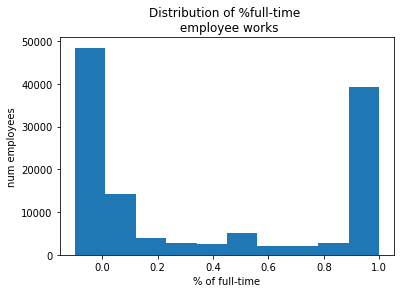

In [23]:
plt.hist(train['FTE'].dropna(),range=[-0.1,1])
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')
plt.show()

From the above plot, we can see that our budgets data favors part-time and contract-based employees as we have more contract employees than full-time employees. 

We have 50k records with negative FTE. Ideally it shouldn’t be negative. This shows that a lot of positions are getting changed and thus resulting in **negative** values. Our strategy would be to normalizing it to 0.

We can assume that contract-based employees are hired for a short-term purpose and that is why they need certain items more frequent than full-time employees who would have such items easily accessible. (NEED to INFER something!)

### Distribution of Categorical Features

Since this data set primarily consists of categorical features, it is very important to look at their distribution. The table below show unique values, count of features, top feature and frequency of top subcategory under each category.

In [14]:
train.describe(include=['O'])

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Text_3,Text_4,Sub_Object_Description,Location_Description,Function_Description,Facility_or_Department,Position_Extra,Program_Description,Fund_Description,Text_1
count,400277,400277,400277,400277,400277,400277,400277,400277,400277,375493,...,109152,53746,91603,162054,342195,53886,264764,304660,202877,292285
unique,37,8,5,3,9,25,11,3,3,602,...,34,244,182,354,687,179,580,421,141,1423
top,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,Regular,Regular Instruction,Extra Duty Pay/Overtime For Support Personnel,School,NON-PROJECT,All Campus Payroll,PROFESSIONAL-INSTRUCTIONAL,GENERAL ELEMENTARY EDUCATION,General Operating Fund,REGULAR INSTRUCTION
freq,86354,203608,254433,257258,223026,102788,97670,306425,343578,47495,...,94462,10762,9159,65524,76890,17697,92136,32829,33467,64896


 Let us look at null values under each category

In [15]:
print(train.isnull().sum())

Function                       0
Use                            0
Sharing                        0
Reporting                      0
Student_Type                   0
Position_Type                  0
Object_Type                    0
Pre_K                          0
Operating_Status               0
Object_Description         24784
Text_2                    312060
SubFund_Description        93422
Job_Title_Description     107534
Text_3                    291125
Text_4                    346531
Sub_Object_Description    308674
Location_Description      238223
FTE                       274206
Function_Description       58082
Facility_or_Department    346391
Position_Extra            135513
Total                       4555
Program_Description        95617
Fund_Description          197400
Text_1                    107992
dtype: int64


Converting our Categorical columns datatype from object to categorical, as this will help in the future for pipeline

In [16]:
cat_list = ['Function','Use','Sharing','Reporting','Student_Type','Position_Type','Object_Type',
              'Pre_K','Operating_Status']

In [110]:
# cat_lab = lambda x: x.astype('category')

# train[cat_list] = train[cat_list].apply(cat_lab,axis=0)

# print(train.dtypes)

Function                  category
Use                       category
Sharing                   category
Reporting                 category
Student_Type              category
Position_Type             category
Object_Type               category
Pre_K                     category
Operating_Status          category
Object_Description          object
Text_2                      object
SubFund_Description         object
Job_Title_Description       object
Text_3                      object
Text_4                      object
Sub_Object_Description      object
Location_Description        object
FTE                        float64
Function_Description        object
Facility_or_Department      object
Position_Extra              object
Total                      float64
Program_Description         object
Fund_Description            object
Text_1                      object
dtype: object


In [17]:
np.round(np.sum(train['Total'] < 0)/np.sum(train['Total']),6)

8e-06

So, we see that we have a small percent of negative budgets. Look’s good for now. Later we will impute them.

**Let's see the sub-categories of our target classes**

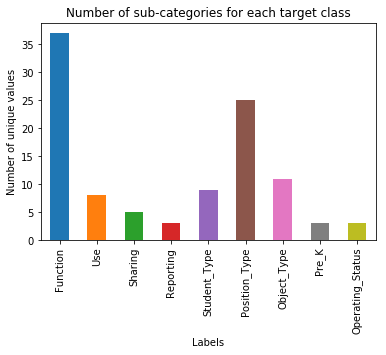

In [18]:
import matplotlib.pyplot as plt

uni_labels = train[cat_list].apply(pd.Series.nunique)

uni_labels.plot(kind='bar')

plt.xlabel('Labels')
plt.ylabel('Number of unique values')
plt.title('Number of sub-categories for each target class')

plt.show()

From the above plot, we see that Function and Position_Type have the highest number of sub-categories while the lowest number of sub-categories are 3 in Operating_Status, Pre_K, and Reporting.

In [19]:
## Let's see if missing Total can be computed based on Job_Title_Description
average_total =train[['Total', 'Job_Title_Description']].groupby(['Job_Title_Description'], as_index = True).mean().sort_values(by = 'Total')
average_total

,Total
Job_Title_Description,
"Dir, Library Media Svcs",-38.695000
"TCHR, K-8 SUB DAY/DAY",-0.580000
INT TEMP EXEC SEC TO THE CEO,-0.550000
SUBSTITUTE GENERAL PREP,-0.330000
CLASSIFIED EDUC CONSUL II,-0.280000
"EDUCATIONAL ASSISTANT, RETIREE",-0.280000
SECURITY OFFICER (EXTERNAL),-0.247500
"TCHR, K-8 LDBD TUTOR-HRLY",-0.162500
ASSOC STRATEGIC IMPLEM OFFICER,0.220000


Let us further explore how the Budget is distributed among different target class

<function matplotlib.pyplot.show(*args, **kw)>

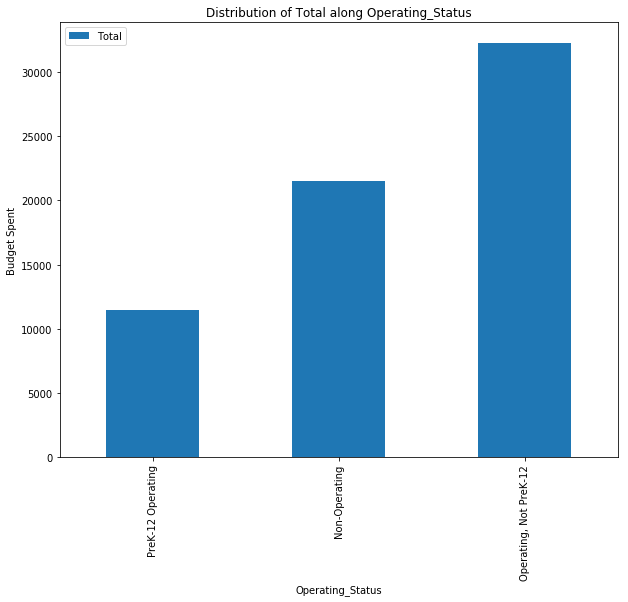

In [24]:
average_total=train[['Total', 'Operating_Status']].groupby(['Operating_Status'], as_index = True).mean().sort_values(by = 'Total')
average_total.plot.bar(figsize = (10,8))
plt.title('Distribution of Total along Operating_Status')
plt.ylabel('Budget Spent')
plt.show

From the above plot we can see that our Budget is highly skewed to the Operating, Not PreK-12 sub-category compared to the rest of the sub-categories.

In [26]:
average_total=train[['Total', 'Object_Type']].groupby(['Object_Type'], as_index = True).mean().sort_values(by = 'Budget')
average_total.plot.bar(figsize = (10,8))
plt.title('Distribution of Budget along Object_Type')
plt.ylabel('Total')
plt.show

KeyError: 'Budget'

<function matplotlib.pyplot.show(*args, **kw)>

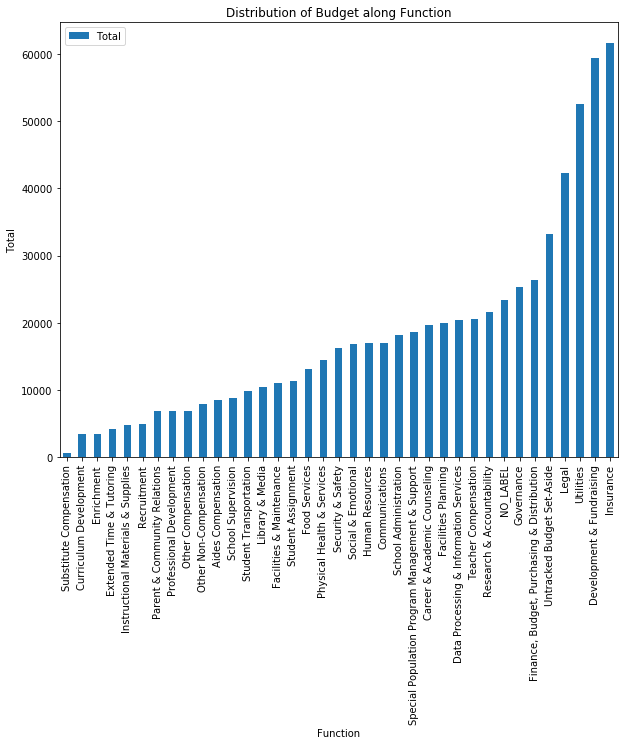

In [27]:
ave_total_func=train[['Total', 'Function']].groupby(['Function'], as_index = True).mean().sort_values(by = 'Total')
ave_total_func.plot.bar(figsize= (10,8))
plt.title('Distribution of Budget along Function')
plt.ylabel('Total')
plt.show

From the above plot, we can see that most of the school budget is spent on the Insurance, Development & Fundraising, Utilities, and Legal activities. Among these, Utilities is the only one that may directly affect the student learning experience. We can see that curriculum development, extended time and tutoring have the least budget spent. 
ERS (our host), really needs to focus on guiding its financial partners to understand their budget spent. We say so, as our host wants to improve student and teacher outcomes as well. 

# Data Cleaning

* In this step, We are removing the white strips and capitalizing our categorical variables 

In [114]:
train_trimmed = train.apply(lambda x: x.str.strip() if x.dtype == "object" else x) #change to category if ran 
#the cell which changes object to category
train_trimmed = train_trimmed.apply(lambda x: x.str.upper() if x.dtype == "object" else x)
train_trimmed.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,TEACHER COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,NO_LABEL,TEACHER,NO_LABEL,NO_LABEL,PREK-12 OPERATING,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,GENERAL FUND,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NON-OPERATING,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,TEACHER COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,TEACHER,BASE SALARY/COMPENSATION,NON PREK,PREK-12 OPERATING,PERSONAL SERVICES - TEACHERS,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,INSTRUCTION - REGULAR,GENERAL PURPOSE SCHOOL,NaN
364634,SUBSTITUTE COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,SUBSTITUTE,BENEFITS,NO_LABEL,PREK-12 OPERATING,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,SUBSTITUTE COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,TEACHER,SUBSTITUTE COMPENSATION,NO_LABEL,PREK-12 OPERATING,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


In [150]:
train_trim_set = train_trimmed[:100]
train_trim_set.head() #100 entries to work on

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,TEACHER COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,NO_LABEL,TEACHER,NO_LABEL,NO_LABEL,PREK-12 OPERATING,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,GENERAL FUND,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NON-OPERATING,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,TEACHER COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,TEACHER,BASE SALARY/COMPENSATION,NON PREK,PREK-12 OPERATING,PERSONAL SERVICES - TEACHERS,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,INSTRUCTION - REGULAR,GENERAL PURPOSE SCHOOL,NaN
364634,SUBSTITUTE COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,SUBSTITUTE,BENEFITS,NO_LABEL,PREK-12 OPERATING,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,SUBSTITUTE COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,TEACHER,SUBSTITUTE COMPENSATION,NO_LABEL,PREK-12 OPERATING,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


# Let's impute the numeric data

* To handle the null values in the numeric data, we are creating a customized imputer function that will impute the missing FTE and Total (Budget spent) based on sub-categories in our training set.   

* Below, we have imputed the data in not such a Pythonic way.

In [115]:
train_impute = train_trimmed.copy()

In [116]:
train_wo_FTEna = train_impute[np.isfinite(train_impute['FTE'])]

In [117]:
train_impute = train_impute[pd.notnull(train_impute['Object_Description'])]

In [118]:
rem = np.sum(train['Object_Description'].isna())
tot = np.round((rem/400277)*100,2) 
#tot = np.sum(train['Unnamed: 0'].value_counts()) #output: 400277
print("Number of records that we will exclude from our entire training set:",rem)
print("This represents",tot,"% of our data. We will see in the next phase how to impute these values \n further.")

Number of records that we will exclude from our entire training set: 24784
This represents 6.19 % of our data. We will see in the next phase how to impute these values 
 further.


In [145]:
pos_FTE = train_wo_FTEna.groupby('Object_Description',as_index=False)[['FTE']].mean()
#pos_FTE.reset_index()
pos_FTE.head()
#train_wo_FTEna.pivot_table(train, values='FTE', index=None, columns=None,aggfunc='mean', 
                    #  fill_value=0, margins=False,dropna=True, margins_name='All')
#pos_FTE.columns
#type(pos_FTE)
#pos_FTE.sort_index(axis=1) == train_impute.sort_index(axis=1)

,Object_Description,FTE
0,ADMINISTRATOR,0.835710
1,AIDES AND PARAPROFESSIONALS,0.900076
2,ALL OTHER SUPPLEMENTS,0.000000
3,ATHLETICS PERSONNEL,0.084004
4,BOARD MEMBERS AND ATTORNEYS,0.916667


In [120]:
pos_FTE_extra = train_wo_FTEna.groupby('Object_Description')[['FTE']].mean()
pos_FTE_extra.index

Index(['ADMINISTRATOR', 'AIDES AND PARAPROFESSIONALS', 'ALL OTHER SUPPLEMENTS',
       'ATHLETICS PERSONNEL', 'BOARD MEMBERS AND ATTORNEYS', 'BONUSES',
       'BUS DRIVERS', 'CLASSROOM TEACHER', 'COMMUNICATION',
       'CONFERENCE REGISTRATION',
       ...
       'TERMINAL LEAVE SICK', 'TERMINAL LEAVE VACATION', 'TIRES AND TUBES',
       'TRANSPORTATION - STUDENTS', 'UNEMPLOYMENT COMPENSATION',
       'UTILITIES - ELECTRICITY', 'UTILITIES - NATURAL GAS',
       'UTILITIES - WATER AND WASTE WATER', 'WORKERS' COMPENSATION',
       'WORKSHOP PARTICIPANT'],
      dtype='object', name='Object_Description', length=101)

In [121]:
type(train_trimmed)

pandas.core.frame.DataFrame

In [122]:
pos_FTE.Object_Description

0                                          ADMINISTRATOR
1                            AIDES AND PARAPROFESSIONALS
2                                  ALL OTHER SUPPLEMENTS
3                                    ATHLETICS PERSONNEL
4                            BOARD MEMBERS AND ATTORNEYS
5                                                BONUSES
6                                            BUS DRIVERS
7                                      CLASSROOM TEACHER
8                                          COMMUNICATION
9                                CONFERENCE REGISTRATION
10                                   CUSTODIAL PERSONNEL
11                                           DIESEL FUEL
12                                         DUES AND FEES
13                                   EMPLOYEE ALLOWANCES
14                               EXTENDED DAY - TEACHERS
15                        EXTRA DUTY PAY NON-INSTRUCTION
16                          EXTRA DUTY PAY-INSTRUCTIONAL
17         EXTRA DUTY PAY/OVERT

In [124]:
for j in pos_FTE['Object_Description']:
    print(pos_FTE['FTE'])

0      0.835710
1      0.900076
2      0.000000
3      0.084004
4      0.916667
5      0.000000
6      1.000000
7      0.747342
8      0.000000
9      0.000000
10     0.750000
11     0.000000
12     0.000000
13     0.000000
14     1.000040
15     0.000000
16     0.000000
17     0.000000
18     0.000000
19     0.000000
20     0.000000
21     0.000000
22     0.000000
23     0.000000
24     0.000000
25     1.000008
26     0.000000
27     0.000000
28     0.000000
29     0.000000
         ...   
71     0.000000
72     0.917173
73     0.000000
74     0.000000
75     0.000000
76     0.000000
77     0.685700
78     0.093159
79     0.586372
80     0.131687
81     0.590063
82     1.000044
83     1.000000
84     0.666429
85     0.400000
86     0.000000
87     0.000000
88     0.000000
89     0.379824
90     0.533985
91     0.000000
92     0.000000
93     0.000000
94     0.000000
95     0.000000
96     0.000000
97     0.000000
98     0.000000
99     0.000000
100    0.000000
Name: FTE, Length: 101, 

In [87]:
import math

In [157]:
for i in train_trim_set['Object_Description']:
    for j in pos_FTE['Object_Description']:
        for k in train_trim_set['FTE']:
            if i == j:
                if math.isnan(k):
                     print("Debug in loop j")
                    if j in pos_FTE:
                        print("Debug in loop j")
                        train_trim_set[i][k]=pos_FTE[j]['FTE']
            

Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in

Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in

Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in loop j
Debug in

In [152]:
train_trim_set.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,TEACHER COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,NO_LABEL,TEACHER,NO_LABEL,NO_LABEL,PREK-12 OPERATING,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,GENERAL FUND,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NON-OPERATING,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,TEACHER COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,TEACHER,BASE SALARY/COMPENSATION,NON PREK,PREK-12 OPERATING,PERSONAL SERVICES - TEACHERS,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,INSTRUCTION - REGULAR,GENERAL PURPOSE SCHOOL,NaN
364634,SUBSTITUTE COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,SUBSTITUTE,BENEFITS,NO_LABEL,PREK-12 OPERATING,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,SUBSTITUTE COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,TEACHER,SUBSTITUTE COMPENSATION,NO_LABEL,PREK-12 OPERATING,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


In [29]:
def impute_custom():
    if train_impute.Object_Description.values == pos_FTE.Object_Description.values:
        print('True')
        if train['FTE'].isna():
            print('working')
            train['FTE'] = pos_FTE['FTE']

* On some research, we found a SKlearn package, [MICE](https://github.com/jeweinberg/Pandas-MICE) that we will implement in Phase 2 of our Final project.

# Numeric pipeline 

In [128]:
num_lab = ['FTE','Total']
numeric_train = train[num_lab].fillna(-1000)

In [129]:
#create dummies of our targets
dummies_lab = pd.get_dummies(train[cat_list])

In [130]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_train,dummies_lab,
                                                               size=0.2,seed=143)

In [131]:
np.sum(X_train.isna())

FTE      0
Total    0
dtype: int64

In [132]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 34.2 MB


In [133]:
train.info() #Int64Index: 400277 entries, 134338 to 415831

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

In [134]:
from sklearn.linear_model import LogisticRegression
#log_model = LogisticRegression()
#fit_x = log_model.fit(X_train,y_train)

In [135]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values 

In [141]:
#numeric pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_lab)),
        ('imputer', Imputer(strategy="median",missing_values=np.nan)),
        ('std_scaler', MinMaxScaler()),
        #('clf', OneVsRestClassifier(LogisticRegression)),
    ])

In [142]:
num_pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['FTE', 'Total'])), ('imputer', Imputer(axis=0, copy=True, missing_values=nan, strategy='median', verbose=0)), ('std_scaler', MinMaxScaler(copy=True, feature_range=(0, 1)))])

# Splitting train and test


Since we are dealing with a multilabel, multiclass situation, we are going to split our training data set in a multi-stratified way. By that we mean we want to make sure all of our sub-categories are present in train and test set. 
If we don't use this custom train-test-split, we may run into issues where our train data has never seen some of the sub-categories and we know that this cannot be the case because we are performing supervised learning.

In [127]:
#source: https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/data/multilabel.py
from warnings import warn

import numpy as np
import pandas as pd

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])


# Classification Model

## Trials with predicting accuracy for One Label at a time

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [24]:
def str_join(df, sep, *cols):
    from functools import reduce
    return reduce(lambda x, y: x.astype(str).str.cat(y.astype(str), sep=sep), 
                      [df[col] for col in cols])

In [25]:
train["all"] = str_join(train, " ", 'FTE', 'Facility_or_Department', 'Function_Description', 'Fund_Description','Job_Title_Description', 'Location_Description', 'Object_Description','Position_Extra', 'Program_Description', 'SubFund_Description', 'Sub_Object_Description','Text_1', 'Text_2', 'Text_3', 'Text_4' )

In [26]:
train['all'].head()

134338    1.0 nan nan General Fund Teacher-Elementary  n...
206341    nan nan RGN  GOB nan (blank) nan CONTRACTOR SE...
326408    1.0 nan nan General Purpose School TCHER 2ND G...
364634    nan nan UNALLOC BUDGETS/SCHOOLS nan Teacher, S...
47683     nan nan NON-PROJECT nan Teacher, Secondary (Hi...
Name: all, dtype: object

In [27]:
# split data into a trainin set (70%), validation set (15%) and blind (holdout) test set (15%)
df_train, df_other = train_test_split(train_trimmed, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_other, test_size=0.5, random_state=42)

### Using OneVsRestClassifier - MultinomialNB

In [28]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [29]:
NB_pipeline.fit(df_train['all'], df_train['Function'])

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...assifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=1))])

In [33]:
prediction = NB_pipeline.predict(df_val['all'])
print('Test accuracy is {}'.format( accuracy_score(df_val['Function'], prediction)))

Prediction ['Teacher Compensation' 'Student Transportation' 'Student Transportation'
 ... 'Instructional Materials & Supplies'
 'Instructional Materials & Supplies' 'Aides Compensation'] :Test accuracy is 0.8249225542120515


In [31]:
prediction

array(['Teacher Compensation', 'Student Transportation',
       'Student Transportation', ...,
       'Instructional Materials & Supplies',
       'Instructional Materials & Supplies', 'Aides Compensation'],
      dtype='<U47')

### Accuracy for all categories

In [35]:
for category in cat_list:
    NB_pipeline.fit(df_train['all'], df_train[category])
    prediction = NB_pipeline.predict(df_val['all'])
    print('Category {} : Test accuracy is {}'.format(category, np.round(accuracy_score(df_val[category], prediction),2)))

Category Function : Test accuracy is 0.8249225542120515
Category Use : Test accuracy is 0.8738882782052563
Category Sharing : Test accuracy is 0.8583991206155691
Category Reporting : Test accuracy is 0.8861297092035575
Category Student_Type : Test accuracy is 0.889577295892875
Category Position_Type : Test accuracy is 0.8710402718097332
Category Object_Type : Test accuracy is 0.8906931814396589
Category Pre_K : Test accuracy is 0.96595716331901
Category Operating_Status : Test accuracy is 0.9561473635122081


### Using OneVsRestClassifier - Logistic Regression

In [36]:
LR_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

In [ ]:
for category in cat_list:
    LR_pipeline.fit(df_train['all'], df_train[category])
    prediction = LR_pipeline.predict(df_val['all'])
    print('Category {} : Test accuracy is {}'.format(category, np.round(accuracy_score(df_val[category], prediction),2)))

Category Function : Test accuracy is 0.9400419706205656
Category Use : Test accuracy is 0.9499517004763333
Category Sharing : Test accuracy is 0.9532493920922022
Category Reporting : Test accuracy is 0.9671230138902768
Category Student_Type : Test accuracy is 0.9657073381965957
Category Position_Type : Test accuracy is 0.9726524765997135
